<a href="https://colab.research.google.com/github/kairavkkp/ML-Tutorials/blob/basic-transformers/Basic-Transformer/basic_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Transformer

[Link](https://www.tensorflow.org/tutorials/text/transformer) to original tutorial.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Mon Apr  5 05:15:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install -q tensorflow_datasets
!pip install -q tensorflow_text

     |████████████████████████████████| 3.4MB 17.1MB/s 


In [4]:
import tensorflow as tf
import tensorflow_text as text
import tensorflow_datasets as tfds
import os
import sys
import numpy as np

In [5]:
os.chdir('/content/drive/MyDrive/Basic-Transformer')

In [6]:
## Suppress Tensorflow warnings

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [ ]:
# Dataset Download
# Portugese to English word translation
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

In [8]:
# Snippet of what train_example looks like
for pt_examples, en_examples in train_examples.batch(1).take(1):

  print("Portuguese Example:")
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print("\nEnglish Example:")
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

Portuguese Example:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .

English Example:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .


In [9]:
# Tokennization and detokenization

model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(f"{model_name}.zip",
                        f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
                        cache_dir='.', cache_subdir='.', extract=True)

'././ted_hrlr_translate_pt_en_converter.zip'

In [10]:
# Loading the tokenizers from the downloaded model
tokenizers = tf.saved_model.load(model_name)

In [11]:
# Let's look at the methods inherited by the Tokenizers

# This is for the English tokenizer
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [12]:
# This is for the Portuguese tokenizer
[item for item in dir(tokenizers.pt) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

As we can see both the tokenizers inherit same methods. It'll be easy for us to perform similar operations on each texts in parallel.

In [13]:
print("Let's tokenize this string.\n")

print("Non Tokenized String: ")
for en in en_examples.numpy():
  print(en.decode('utf-8'))

print()

# Encoding the string
encoded = tokenizers.en.tokenize(en_examples)

print("Tokenized string: ")
for row in encoded.to_list():
  print(row)
print()

print('Now, lets try to detokenize the string and see if we get back the original string back.\n')

# Decoding the string
decoded = tokenizers.en.detokenize(encoded)

print('Detokenized String:')
for row in decoded.numpy():
  print(row.decode('utf-8'))

Let's tokenize this string.

Non Tokenized String: 
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .

Tokenized string: 
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]

Now, lets try to detokenize the string and see if we get back the original string back.

Detokenized String:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .


In [14]:
## We can use the lookup method to get the token-text from token-IDs

tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability', b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage', b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip', b'##ity', b'.', b'[END]']]>

We can see that the word `searchability` is tokenized in a sub-word manner. It is comprised of two tokens, namely `search` and `##ability`. Similarly it is the same for `serendipity`.


## Setup Input pipeline


In [15]:
def tokenize_pairs(pt, en):
  pt = tokenizers.pt.tokenize(pt)
  pt = pt.to_tensor()

  en = tokenizers.en.tokenize(en)
  en = en.to_tensor()

  return pt, en

In [16]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [17]:
def make_batches(ds):
  return (
      ds.cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE)
  )

In [18]:
# Preparing batches for Training and Validation
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

As we know that Transformers have a disadvantage that if the training set like text, doesn't have any positional encoding the transformers will just treat them as Bag of Words.

### Positional Encoding

$$PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}})$$

$$PE_{(pos, 2i+1)} = cos(pos/10000^{2i/d_{model}})$$

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.

In [19]:
# Creating Positional Encoding for the train examples.
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  ## handling PE for Even indices
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # handling PE for Odd indices
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


In [20]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
pos_encoding = pos_encoding[0]
pos_encoding.shape

TensorShape([2048, 512])

In [21]:
# Inverting the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2)) ## Here d//2, will provide the output in integer format
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

In [22]:
import matplotlib.pyplot as plt

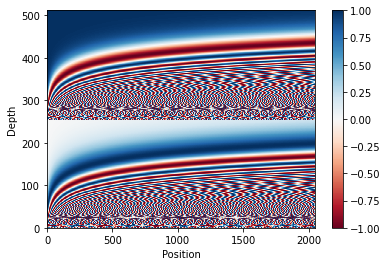

In [23]:
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Masking

Since we added padding, we don't want our model to treat padding as an input. To overcome this we'll introduce Masking. We'll create a Mask Tensor, which will have value `1.`, wherever there's padding added in our input sequence.

In [24]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  return seq[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)

In [25]:
# Trying to see the working of the above function

x = tf.constant([[1,2,3,4,0],[2,1,0,1,0], [0,0,0,0,1]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 1.]]],


       [[[0., 0., 1., 0., 1.]]],


       [[[1., 1., 1., 1., 0.]]]], dtype=float32)>


The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [26]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size,size)), -1, 0)

  ## Info regarding 
  ## tf.linalg.band_part(input, 0, -1) ==> Upper triangular part.
  ## tf.linalg.band_part(input, -1, 0) ==> Lower triangular part.
  ## tf.linalg.band_part(input, 0, 0) ==> Diagonal.

  ## Later,
  ## Inversing 1->0 and 0->1.
  return mask # dims: (size, size)

In [27]:
x = tf.random.uniform((1,3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

As we can see here, that we are choosing the lower triangular region in this example, which helps in the look ahead stage, which words to choose and which not to choose.

## Scaled Dot Product Attention

The Attention Function is comprised of three vectors, namely, Query, Key and Value vectors. For more details, go through this [blog](https://towardsdatascience.com/transformers-89034557de14). 

The Formula to calculate Attention is:

$$Attention(Q,K,V) = softmax_k\left( \dfrac{QK^T}{\sqrt{d_k}} \right ) V$$

$d_k$ is used to scale the Dot Product between `Q` and `K`, in order to overcome vanishing gradients. `Q` and `K` will follow mean `0` and variance `1`, so their product will follow mean `1` and std $d_k$, So $\sqrt{d_k}$ is used for scaling.

<div align="center">
<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" />
</div>

In [28]:
def scaled_dot_product_attention(q, k, v, mask):

  ## Transpose_b is used to invert the k matrix
  matmul_q_k = tf.matmul(q, k, transpose_b=True) ## (..., seq_len_q, seq_len_k)

  dk = tf.cast(tf.shape(k)[-1], tf.float32) ## seq_len_k

  scaled_attention_logits = matmul_q_k / tf.math.sqrt(dk)

  if mask is not None:
    scaled_attention_logits += (mask * -1e9) # -1e9 is close to negative infinity
  
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)

  return output, attention_weights

In [29]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
  print("Attention weights are:")
  print(temp_attn)
  print("Output is:")
  print(temp_out)

In [30]:
np.set_printoptions(suppress=True)

In [31]:
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)

temp_v = tf.constant([[1,0],
                      [10,0],
                      [100,5],
                      [1000,6]], dtype=tf.float32)

print('This `query` aligns with the second `key`,so the second `value` is returned.\n')
temp_q = tf.constant([[0,10,0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

print()

print("This query aligns with a repeated key (third and fourth), so all associated values get averaged.\n")
temp_q = tf.constant([[0,0,10]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)


print()

print("This query aligns equally with the first and second key, so their values get averaged.\n")
temp_q = tf.constant([[10,10,0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)


print()

print("Pass all the queries together.\n")
temp_q = tf.constant([[10,10,0],
                      [10,0,0],
                      [0,10,0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)


This `query` aligns with the second `key`,so the second `value` is returned.

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)

This query aligns with a repeated key (third and fourth), so all associated values get averaged.

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)

This query aligns equally with the first and second key, so their values get averaged.

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)

Pass all the queries together.

Attention weights are:
tf.Tensor(
[[0.5 0.5 0.  0. ]
 [1.  0.  0.  0. ]
 [0.  1.  0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[ 5.5  0. ]
 [ 1.   0. ]
 [10.   0. ]], shape=(3, 2), dtype=float32)


## Multi-Head Attention

- Linear Layers and spilt into Heads.
- Scaled dot-product attention
- Concatenation of heads
- Final Linear Layer

<div align="center">

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png">
</div>

In [32]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0
    self.depth = d_model // self.num_heads # Value converts to Integer

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """
    Should return a tensor of (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
  
    batch_size = tf.shape(q)[0]

    q = self.wq(q)
    k = self.wk(k)
    v = self.wv(v)

    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)

    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

    output = self.dense(concat_attention)

    return output, attention_weights


In [33]:
## Lets try out the MHA class

temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))
out, attn = temp_mha.call(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network


In [34]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
                              tf.keras.layers.Dense(dff, activation='relu'),
                              tf.keras.layers.Dense(d_model)
  ])

In [35]:
## Testing PWFFN

sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and Decoder

<div align="center">

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" >

</div>

## Encoder Layer

It consists of:
- Multi-Head Attention (with padding mask)
- Point-wise Feed Forward network


In [36]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super().__init__()
    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    attn_output, _ = self.mha(x, x, x, mask)
    attn_output = self.dropout1(attn_output, training=training)

    out1 = self.layernorm1(x + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)

    return out2

In [37]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

In [38]:
sample_encoder_layer_op = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)

In [39]:
sample_encoder_layer_op.shape

TensorShape([64, 43, 512])

## Decoder Layer

It consist of:
- Masked multi-head attention (with look ahead mask and padding mask)
- Multi-head attention (with padding mask). V (value) and K (key) receive the encoder output as inputs. Q (query) receives the output from the masked multi-head attention sublayer.
- Point wise feed forward networks

In [40]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super().__init__()
        
    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)


    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    attn1, attn_weights_block1 = self.mha1(x,x,x,look_ahead_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1,
                                           padding_mask)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)

    return out3, attn_weights_block1, attn_weights_block2

In [41]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_op,
    False, None, None)

sample_decoder_layer_output.shape

TensorShape([64, 50, 512])

## Encoder

It consists of:
- Input Embedding
- Positonal Encoding
- N Encoder Layers

In [42]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                        for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)
  
  def call(self, x, training, mask):
    
    seq_len = tf.shape(x)[1]

    x = self.embedding(x)

    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    
    return x


In [43]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)

(64, 62, 512)


## Decoder 
It consists of:
- Output Embedding
- Positional Encoding
- N Decoded Layers

In [44]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads,dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super().__init__()
    
    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                      for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    return x, attention_weights


In [45]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Transformer


In [46]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super().__init__()
    self.tokenizer = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)
    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)
    
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  
  def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):
    enc_output = self.tokenizer(inp, training, enc_padding_mask)
    dec_output, attention_weights = self.decoder(tar, enc_output, training,
                                                 look_ahead_mask, 
                                                 dec_padding_mask)
    
    final_output = self.final_layer(dec_output)
    return final_output, attention_weights

In [47]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Hyperparameters


In [48]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## Optimizer

Custom Learning Rate Scheduler, with ADAM Optimizers.


In [49]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)  ## Reciprocal of sqrt \
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [50]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)


In [51]:
temp_learning_rate_schedule = CustomSchedule(d_model)

Text(0.5, 0, 'Train Step')

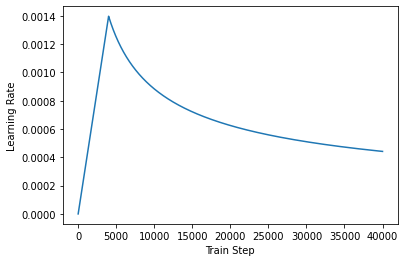

In [52]:
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and Metrics

As the target sequences are padded, we need to make sure that our predicted output should also be padded while calculating loss.

In [53]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)

In [54]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)

  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, tf.float32)
  mask = tf.cast(mask, tf.float32)

  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [55]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training & Checkpoint


In [56]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    dff=dff,
    num_heads=num_heads,
    input_vocab_size=tokenizers.pt.get_vocab_size(),
    target_vocab_size=tokenizers.en.get_vocab_size(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate
)

In [66]:
def create_mask(inp, tar):
  enc_padding_mask = create_padding_mask(inp)
  dec_padding_mask = create_padding_mask(inp)

  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

In [58]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print("Latest Checkpoint Restored!!!")
  

The `target` is split into two categories, `tar_inp`, which is the input to the decoder and `tar_real`, which is same as the previous type, but shifted by 1. The model will try to predict the next word everytime it gets the line.


In [64]:
EPOCHS = 20


In [60]:
train_step_signature = [
                 tf.TensorSpec(shape=(None, None), dtype = tf.int64),
                 tf.TensorSpec(shape=(None, None), dtype = tf.int64),
]

In [67]:
@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_mask(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp,
                                 True, enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    
    loss = loss_function(tar_real, predictions)
  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [62]:
import time

In [68]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)
    # Printing at every 50 batches
    if batch % 50 == 0:
      print(f'Epoch: {epoch + 1}, Batch: {batch}, Loss: {train_loss.result():.4f}, Accuracy: {train_accuracy.result():.4f}')
  # Saving Checkpoint every 5 epochs
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving Checkpoint for epoch {epoch+1} at {ckpt_save_path}.')

  print(f'Epoch: {epoch + 1}, Loss: {train_loss.result():.4f}, Accuracy: {train_accuracy.result():.4f}')

  print(f'Time Taken for 1 epoch: {time.time() - start:.2f} secs.\n')
  


Epoch: 1, Batch: 0, Loss: 8.8521, Accuracy: 0.0000
Epoch: 1, Batch: 50, Loss: 8.7831, Accuracy: 0.0209
Epoch: 1, Batch: 100, Loss: 8.6871, Accuracy: 0.0330
Epoch: 1, Batch: 150, Loss: 8.5768, Accuracy: 0.0370
Epoch: 1, Batch: 200, Loss: 8.4369, Accuracy: 0.0393
Epoch: 1, Batch: 250, Loss: 8.2683, Accuracy: 0.0405
Epoch: 1, Batch: 300, Loss: 8.0799, Accuracy: 0.0413
Epoch: 1, Batch: 350, Loss: 7.8844, Accuracy: 0.0425
Epoch: 1, Batch: 400, Loss: 7.6964, Accuracy: 0.0494
Epoch: 1, Batch: 450, Loss: 7.5286, Accuracy: 0.0582
Epoch: 1, Batch: 500, Loss: 7.3832, Accuracy: 0.0655
Epoch: 1, Batch: 550, Loss: 7.2511, Accuracy: 0.0729
Epoch: 1, Batch: 600, Loss: 7.1267, Accuracy: 0.0809
Epoch: 1, Batch: 650, Loss: 7.0125, Accuracy: 0.0888
Epoch: 1, Batch: 700, Loss: 6.9057, Accuracy: 0.0962
Epoch: 1, Batch: 750, Loss: 6.8072, Accuracy: 0.1029
Epoch: 1, Batch: 800, Loss: 6.7138, Accuracy: 0.1093
Epoch: 1, Loss: 6.6979, Accuracy: 0.1104
Time Taken for 1 epoch: 118.10 secs.

Epoch: 2, Batch: 0, Los

## Evaluate

Steps:
- Encode the input (portuguese) statement using  `pt` tokenizer.
- Decoder input is initialized to  `[START]` token.
- Calculate Padding and Look Ahead Masks.
- The `decoder` predicts using the encoder output and its own output (self-attention).
- The model is predicting output from each input word, which is useless and only output from the last word should be used.
- Concatenate the predicted word to the decoder input and pass it to the decoder.
- In this approach the decoder predicts the next word based on the previous words it predicted.

In [70]:
# Context for Start and End for below snippet
tokenizers.en.tokenize([''])

<tf.RaggedTensor [[2, 3]]>

In [75]:
def evaluate(sentence, max_length = 40):

  ## Converting sentence to PT tokens
  sentence = tf.convert_to_tensor([sentence])
  sentence = tokenizers.pt.tokenize(sentence).to_tensor()

  encoder_input = sentence

  ## Look the cell above
  start, end = tokenizers.en.tokenize([''])[0]

  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)

  for  i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_mask(
        encoder_input, output
    )

    predictions, attention_weights = transformer(encoder_input,
                                                 output,
                                                 True,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # Selecting the last word
    predictions = predictions[:, -1:, :]

    predicted_id = tf.argmax(predictions, axis=-1)

    # Concatenate the predicted_id to the output as an input to the decoder
    output = tf.concat([output, predicted_id], axis=-1)

    ## If the predicted_id is end token, return result.
    if predicted_id == end:
      break

  text = tokenizers.en.detokenize(output)[0]
  tokens = tokenizers.en.lookup(output)[0]

  return text, tokens, attention_weights


In [72]:
def print_translation(sentence, tokens, gt):
  print(f'{"Input":15s}: {sentence}')
  print(f'{"Predictions":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground Truth":15s}: {gt}')

In [87]:
example_dict = {
    "sentence":[
                "este é um problema que temos que resolver.",
                "os meus vizinhos ouviram sobre esta ideia.",
                "vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."
    ],
    "ground_truth": [
                "this is a problem we have to solve .",
                "and my neighboring homes heard about this idea .",
                "so i \'ll just share with you some stories very quickly of some magical things that have happened ."                     
    ]
}

In [116]:
def translate(example_dict):
  for (sentence, gt) in zip(example_dict["sentence"],example_dict["ground_truth"]):
    translated_text, translated_tokens, attention_weights = evaluate(sentence)
    print_translation(sentence, translated_text, gt)
    print()

In [117]:
translate(example_dict)

Input          : este é um problema que temos que resolver.
Predictions    : this is a problem that we have to fix .
Ground Truth   : this is a problem we have to solve .

Input          : os meus vizinhos ouviram sobre esta ideia.
Predictions    : my neighbors heard about this idea .
Ground Truth   : and my neighboring homes heard about this idea .

Input          : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predictions    : so i ' m going to share a lot of with you some stories of some magical stuff that happened .
Ground Truth   : so i 'll just share with you some stories very quickly of some magical things that have happened .



## Attention Plots




In [106]:
sentence = "este é um problema que temos que resolver."
gt = "this is a problem we have to solve ."

In [107]:
translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input          : este é um problema que temos que resolver.
Predictions    : this is a problem that we have to do .
Ground Truth   : I read about triceratops in the encyclopedia.


In [108]:
def plot_attention_head(in_tokens, translated_tokens, attention):

  # Skipping the <START> TOKEN
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)


In [109]:
head = 0
attention_heads = tf.squeeze(
    attention_weights['decoder_layer4_block2'], 0
)
attention = attention_heads[head]
attention.shape

TensorShape([11, 11])

In [110]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'um', b'problema', b'que', b'temos',
       b'que', b'resolver', b'.', b'[END]'], dtype=object)>

In [111]:
translated_tokens

<tf.Tensor: shape=(12,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'a', b'problem', b'that', b'we',
       b'have', b'to', b'do', b'.', b'[END]'], dtype=object)>

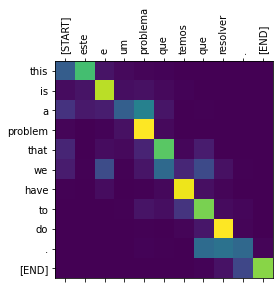

In [112]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [113]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16,8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)
    plot_attention_head(in_tokens, translated_tokens, head)
    ax.set_xlabel(f'Head: {h+1}')

  plt.tight_layout()
  plt.show()

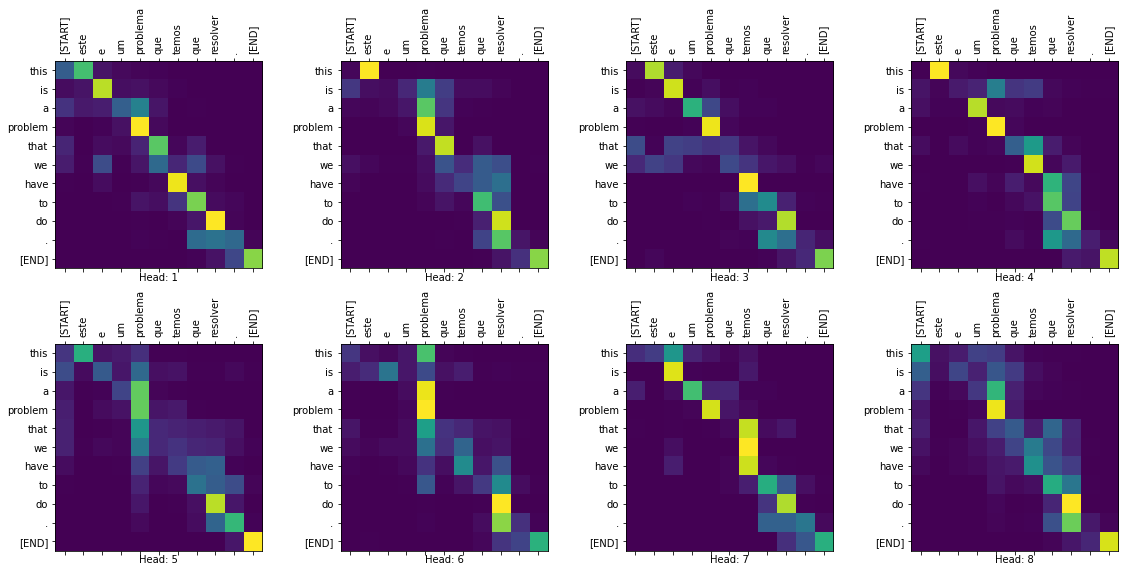

In [114]:
plot_attention_weights(sentence, translated_tokens, 
                      attention_weights['decoder_layer4_block2'][0])

Input          : Eu li sobre triceratops na enciclopédia.
Predictions    : i read about triophots on encyclolopedia .
Ground Truth   : I read about triceratops in the encyclopedia.


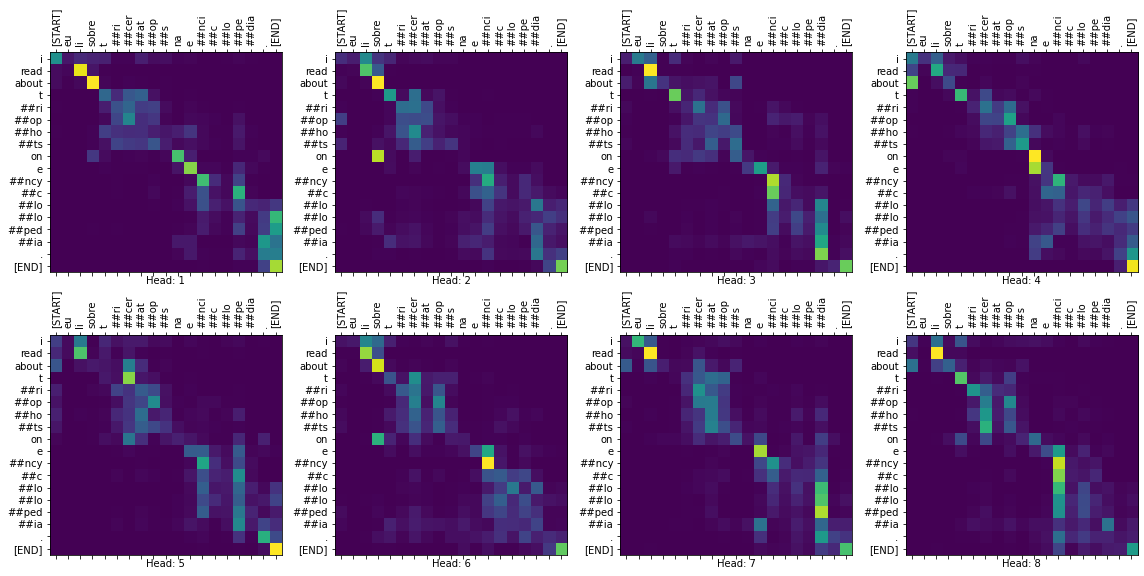

In [115]:
## One more example, which is not in the training set.
sentence = "Eu li sobre triceratops na enciclopédia."
ground_truth = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])